In [1]:
"""
    Experimentation with neural networks on a datset of MRI covid/non-covid images.
    
    Created: 10/21/2020
    Author(s): Ben Flanders (brf97486)
    
    
    Potential source of getting all layer predictions: https://stackoverflow.com/questions/51677631/keras-tensorflow-get-predictions-or-output-of-all-layers-efficiently

"""

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *

from DataHandler import dataHandler


In [2]:
dh = dataHandler() # data handler object. See DataHandler.py for more information.

# ALTER HYPERPARAMETERS HERE
BATCH_SIZE = 16




In [3]:
dataset = dh.get_all_data_labeled(shuffle=True)

In [4]:
# check that all data is in place
assert len(dh.get_non_covid_data_fp()) == 397 and len(dh.get_covid_data_fp()) == 349 and len(dh.get_all_data_labeled()) == (397 + 349)

In [5]:
datapoint = dataset[0] # get some datapoint from the dataset
random_img = cv2.imread(datapoint[0])

Label:  1.0
filepath:  /Users/benflanders/Documents/github/COVID-19-CT-image-analysis-CSCI_8955/data/CT_COVID/2020.02.17.20024018-p17-61%1.png
image dimensions:  (391, 512, 3)
image datatype:  uint8
image max:  255
image min


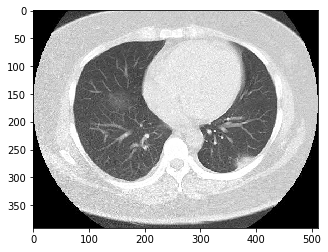

In [6]:
print("Label: ", datapoint[1])
print("filepath: ", datapoint[0])
print("image dimensions: ", random_img.shape)
print("image datatype: ", random_img.dtype)
print("image max: ", random_img.max())
print("image min")
plt.imshow(random_img)

In [7]:
# split the dataset into a train and test dataset

split_point = int(len(dataset) * .8 ) # 80 / 20 split

train_data = dataset[0:split_point]
test_data = dataset[split_point:]

assert len(train_data) + len(test_data) == (397 + 349) # ensure all expected data is present

In [8]:
# get the image data and load it into memory

train_X = np.asarray([dh.load_image(fp, resize=True) for (fp, label) in train_data]).astype('uint8')
train_y = np.asarray([label for (fp, label) in train_data]).astype('float16')

test_X = np.asarray([dh.load_image(fp, resize=True) for (fp, label) in test_data]).astype('uint8')
test_y = np.asarray([np.asarray(label) for (fp, label) in test_data]).astype('float16')

In [9]:
# Sequential API
'''
model = tf.keras.Sequential(
    [
        Input([299, 299, 3], dtype=tf.uint8),
        tf.keras.layers.Lambda(lambda i:tf.cast(i, tf.float32)),
        Lambda(lambda x:tf.keras.applications.inception_v3.preprocess_input(x)),
        tf.keras.applications.InceptionV3(weights='imagenet', include_top=False),
        Flatten(),
        Dense(16, activation='relu', dtype=tf.float32),
        Dense(1, activation='sigmoid', dtype=tf.float32)    
    ])
'''

"""
# Functinal API

i = Input([299, 299, 3], dtype=tf.uint8)
x = Lambda(lambda x: tf.cast(x, tf.float32))(i)

#x = tf.cast(i, tf.float32)
#x = tf.keras.applications.inception_v3.preprocess_input(x)
core = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))(x)
core.trainable = False
#x = core(i)
x = Flatten()(core)
x = Dense(16, activation='relu', dtype=tf.float32)(x)
prediction = Dense(1, activation='sigmoid', dtype=tf.float32)(x)

model = tf.keras.Model(inputs=[i], outputs=[prediction])


#img = tf.image.decode_jpeg(tf.io.read_file(datapoint[0]))
#result = model(img)

# model = tf.keras.applications.InceptionV3(include_top=)


# compile model to train based on mse using the Adam Optimizer. Metrics displayed is accuracy.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')

for lay in model.layers:
    if lay.name == 'inception_v3':
        lay.trainable = False
        
"""

"\n# Functinal API\n\ni = Input([299, 299, 3], dtype=tf.uint8)\nx = Lambda(lambda x: tf.cast(x, tf.float32))(i)\n\n#x = tf.cast(i, tf.float32)\n#x = tf.keras.applications.inception_v3.preprocess_input(x)\ncore = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))(x)\ncore.trainable = False\n#x = core(i)\nx = Flatten()(core)\nx = Dense(16, activation='relu', dtype=tf.float32)(x)\nprediction = Dense(1, activation='sigmoid', dtype=tf.float32)(x)\n\nmodel = tf.keras.Model(inputs=[i], outputs=[prediction])\n\n\n#img = tf.image.decode_jpeg(tf.io.read_file(datapoint[0]))\n#result = model(img)\n\n# model = tf.keras.applications.InceptionV3(include_top=)\n\n\n# compile model to train based on mse using the Adam Optimizer. Metrics displayed is accuracy.\nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')\n\nfor lay in model.layers:\n    if lay.name == 'inception_v3':\n        lay.trainable = False\n        \n"

In [10]:
inception_model = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False)
inception_model.trainable = False
x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(16, activation='relu', dtype=tf.float32)(x)
prediction = Dense(1, activation='sigmoid', dtype=tf.float32)(x)





complete_model = tf.keras.Model(inputs=inception_model.input,outputs=prediction)

visualization_model = tf.keras.Model(inputs=inception_model.input, 
                                    outputs=[l.output for l in complete_model.layers[1:] if 'conv' in l.name])



complete_model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')

for lay in complete_model.layers:
    lay.trainable = True

# just the very last layer should be trainable for now
complete_model.layers[len(complete_model.layers)-1].trainable = True




In [11]:
complete_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
visualization_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
complete_model.fit(x=train_X, y=train_y, batch_size=BATCH_SIZE, validation_data=(test_X, test_y), epochs=100)

Epoch 1/100
38/38 [==============================] - 28s 744ms/step - loss: 4.4060 - acc: 0.5252 - val_loss: 1.9273 - val_acc: 0.5733
Epoch 2/100
38/38 [==============================] - 29s 752ms/step - loss: 1.7717 - acc: 0.5604 - val_loss: 3.6703 - val_acc: 0.4933
Epoch 3/100
38/38 [==============================] - 30s 789ms/step - loss: 1.9240 - acc: 0.5688 - val_loss: 1.4889 - val_acc: 0.5867
Epoch 4/100
38/38 [==============================] - 31s 805ms/step - loss: 1.5038 - acc: 0.6124 - val_loss: 1.9077 - val_acc: 0.5600
Epoch 5/100
38/38 [==============================] - 29s 771ms/step - loss: 1.1782 - acc: 0.6695 - val_loss: 1.4871 - val_acc: 0.5867
Epoch 6/100
38/38 [==============================] - 31s 812ms/step - loss: 1.2371 - acc: 0.6460 - val_loss: 1.8832 - val_acc: 0.5867
Epoch 7/100
38/38 [==============================] - 28s 732ms/step - loss: 1.2503 - acc: 0.6527 - val_loss: 1.1972 - val_acc: 0.6667
Epoch 8/100
38/38 [==============================] - 29s 768ms

Epoch 62/100
38/38 [==============================] - 30s 780ms/step - loss: 0.3037 - acc: 0.8523 - val_loss: 1.7156 - val_acc: 0.6600
Epoch 63/100
38/38 [==============================] - 31s 815ms/step - loss: 0.1822 - acc: 0.9228 - val_loss: 1.6234 - val_acc: 0.7200
Epoch 64/100
38/38 [==============================] - 29s 772ms/step - loss: 0.2442 - acc: 0.8926 - val_loss: 2.0797 - val_acc: 0.6400
Epoch 65/100
38/38 [==============================] - 29s 754ms/step - loss: 0.2092 - acc: 0.9161 - val_loss: 1.7880 - val_acc: 0.6800
Epoch 66/100
38/38 [==============================] - 29s 774ms/step - loss: 0.1402 - acc: 0.9446 - val_loss: 2.2835 - val_acc: 0.6400
Epoch 67/100
38/38 [==============================] - 31s 826ms/step - loss: 0.1951 - acc: 0.9211 - val_loss: 1.5835 - val_acc: 0.7067
Epoch 68/100
10/38 [======>.......................] - ETA: 17s - loss: 0.2919 - acc: 0.8750

In [ ]:
conv_lays = []

count = 0
    
for lay in complete_model.layers:
    if 'conv' in lay.name:
        conv_layer = lay
        conv_lays.append(lay)
        
print("Number of convolution layers: ", len(conv_lays))

In [ ]:
kernel_images = conv_layer.kernel

In [ ]:
print(kernel_images.shape)

plt.imshow(kernel_images[0][0])

In [ ]:

datapoint = test_data[len(test_data)-1]

img_data = np.asarray([dh.load_image(datapoint[0], resize=True)]).astype('uint8')

print("datapoint label: ", datapoint[1])
print("model prediction: ", complete_model.predict(img_data))

all_layer_outputs = visualization_model.predict(img_data)

In [ ]:

for l in inception_layer.layers[2:]:
    if 'conv' in l.name:
        print(l.output) 


In [ ]:
layer_0_conv_out = all_layer_outputs[93][0]
layer_0_conv_out.shape
plt.imshow(layer_0_conv_out[:,:,0])